In this project, I will be doing a brief exploration of the CalEnviroScreen dataset and then implementing various ensemble methods using scikit-learn.

I first clean the data and compare different communities. Then I try using a single decision tree to make a prediction on which score bracket a certain tract lies in - i.e. the response variable is CES 3.0 Percentile Range, and saw it wasn't the best performing method. I then moved on to ensemble methods such as random forests and bagging because they use multiple trees and typically perform better than single decision trees. By the end I examined and compared how different ensemble methods would perform on the data.

In [1]:
# Load dependencies
import urllib
import os.path
from shutil import copyfile

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
# Install packages
!pip install xlrd
!pip install graphviz

### The data: CalEnviroScreen<a name='data'></a>

[California Communities Environmental Health Screening Tool (CalEnviroScreen)](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30), which uses demographic and environmental information to identify communities that are susceptible to various types of pollution. The various variables in this dataset contribute to the CES score, which reflects a community's environmental conditions and its vulnerability to environmental pollutants. 

Loading the data

In [3]:
filename = 'ces3results.xlsx'
xl = pd.ExcelFile(filename)
print(xl.sheet_names) # display a list of the sheets in the spreadsheet

df0 = xl.parse(xl.sheet_names[0]) # display the first sheet as Pandas dataframe
df0.head()

['CES 3.0 (2018 Update)', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),Yes,0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),Yes,0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),Yes,0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


I am starting by taking a look at the data for Los Angeles County. I will be data cleaning to remove trailing and leading spaces from the county names. 

In [4]:
df0["California County"] = df0["California County"].str.strip()
la = df0[df0['California County'] == 'Los Angeles']
la_ft = la[['Census Tract', 'ZIP', 'CES 3.0 Score', 'Housing Burden', 'Unemployment',
            'Poverty', 'Education', 'Traffic', 'Solid Waste', 'Pesticides', 
            'Groundwater Threats', 'Pollution Burden']]
la_ft.head()

,Census Tract,ZIP,CES 3.0 Score,Housing Burden,Unemployment,Poverty,Education,Traffic,Solid Waste,Pesticides,Groundwater Threats,Pollution Burden
5,6037204920,90023,80.726872,22.0,11.6,66.4,53.1,2943.44,3.85,0.000000,25.00,76.731417
8,6037206050,90023,79.025293,31.7,28.5,75.7,50.4,2810.82,22.10,0.000000,16.25,77.090566
14,6037205120,90023,78.043685,24.6,16.9,78.3,61.4,887.21,14.75,0.000000,37.25,75.614761
16,6037291220,90247,77.497763,37.3,8.9,53.4,31.4,2467.25,3.45,68.625026,65.55,79.989779
20,6037239202,90001,76.043426,38.7,13.6,76.3,51.4,930.42,15.00,0.000000,29.85,66.157806


Next I wanted to compare two communities, specifically the records from Census Tract `6037700600` and `6037206300`.

In [6]:
ind1 = la_ft[la_ft['Census Tract'] == 6037700600]
ind2 = la_ft[la_ft['Census Tract'] == 6037206300]
ind1.append(ind2)

,Census Tract,ZIP,CES 3.0 Score,Housing Burden,Unemployment,Poverty,Education,Traffic,Solid Waste,Pesticides,Groundwater Threats,Pollution Burden
7055,6037700600,90210,9.085757,10.9,4.4,13.4,9.5,910.71,0.5,0.057234,3.6,47.957637
123,6037206300,90013,65.941058,30.7,41.1,94.9,32.2,645.70,13.7,0.000000,13.7,69.787591


These two communities are extremely different -- one has a low CES 3.0 score and one has a high score, and the values of the features are also pretty varied. Now I will be examining how these communities compare using histograms of the `CES 3.0 Score` and `Poverty` for all Los Angeles tractsof some of the columns. 

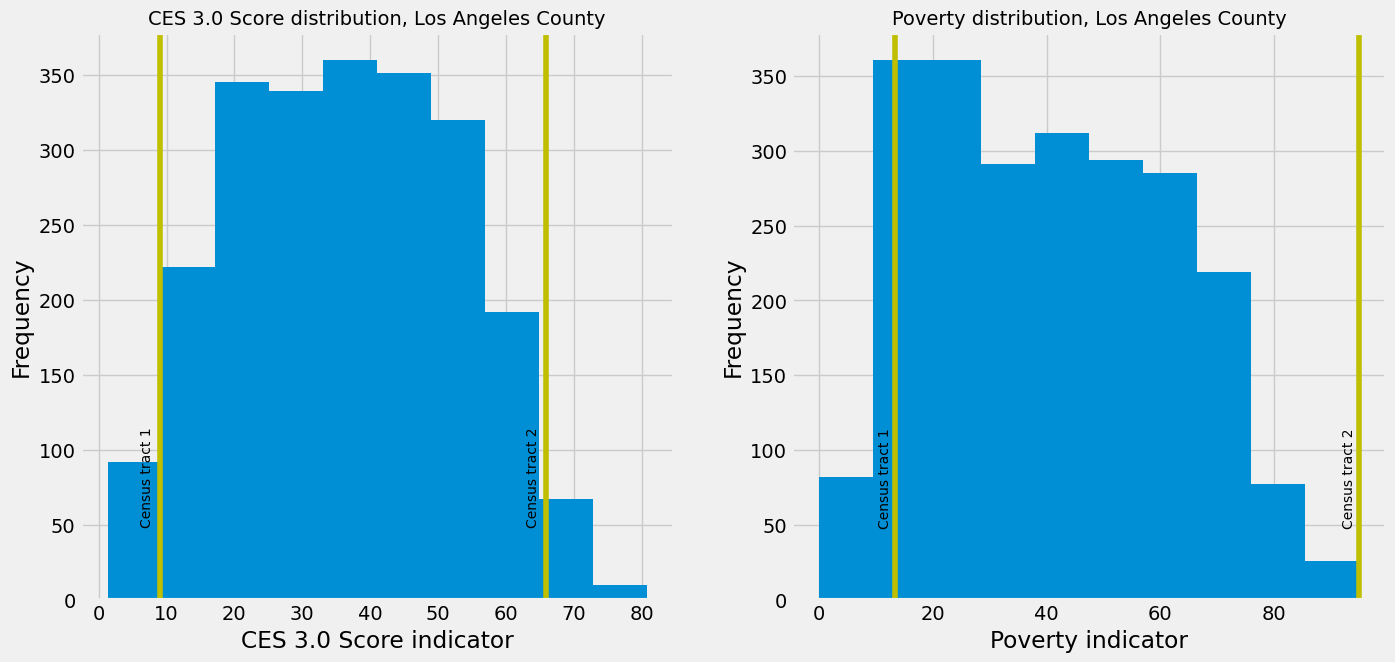

In [7]:
plt.figure(figsize = (15,7))

plots = ['CES 3.0 Score', 'Poverty']

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.hist(la_ft[plots[i]])
    plt.axvline(ind1[plots[i]].values, c = 'y')
    plt.text(ind1[plots[i]].values-3, 50, "Census tract 1", fontsize = 10, rotation = 90)
    plt.axvline(ind2[plots[i]].values, c = 'y')
    plt.text(ind2[plots[i]].values-3, 50, "Census tract 2", fontsize = 10, rotation = 90)
    plt.title(plots[i] + " distribution, Los Angeles County", fontsize = 14)
    plt.xlabel(plots[i] + " indicator")
    plt.ylabel("Frequency")

Now I am looking at the demographic profiles of the communities which is housed in the `Demographic profile` sheet of the Excel file.

In [8]:
# load demographic profile
dp = xl.parse('Demographic profile', header = 1)
dp = dp.reset_index()
dp = dp.rename(columns = {'Unnamed: 0': 'Census Tract',
                          'Unnamed: 1': 'CES 3.0 Score',
                          'Unnamed: 2': 'CES 3.0 Percentile',
                          'Unnamed: 3': 'CES 3.0 Percentile Range',
                          'Unnamed: 4': 'Total Population',
                          'Unnamed: 5': 'California County'
    
})

In [9]:
demo1 = dp[dp['Census Tract'] == 6037700600]
demo2 = dp[dp['Census Tract'] == 6037206300]
demo1.append(demo2)

,index,Census Tract,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,Total Population,California County,Children < 10 (%),Pop 11-64 years (%),Elderly > 65 (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other (%)
7055,7055,6037700600,9.085757,11.022828,10-15%,5537,Los Angeles,9.2,67.0,23.8,5.4,84.8,0.9,0.0,4.3,4.6
123,123,6037206300,65.941058,98.448733,95-100% (highest scores),7540,Los Angeles,2.0,89.1,8.9,24.9,16.7,52.8,1.0,2.3,2.2


---

### Implementing decision trees with scikit-learn<a name = 'sk'></a>

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree

Now I look back into the dataset as whole and do a data-cleaning operation that renames one of the qualitative columns that will be used for building the decision tree. 

In [11]:
# Run this cell
df0.rename(columns={'CES 3.0 \nPercentile Range':'CES 3.0 Percentile Range'}, inplace = True)
df0.head()

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),Yes,0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),Yes,0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),Yes,0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


The `CES 3.0 Percentile Range` is intended to identify "California communities that are most affected by many sources of pollution, and that are often especially vulnerable to pollution’s effects... A census tract with a high score is one that experiences higher pollution burden and vulnerability than census tracts with low scores."

I'll be using the features to predict which score bracket a certain tract lies in with our response variable being `CES 3.0 Percentile Range`. I am focusing on the 91st percentile and above, and the 10th percentile and below.

Now I'm taking a look at the unique values for percentile range in our target variable.

In [12]:
df0['CES 3.0 Percentile Range'].unique()

array(['95-100% (highest scores)', '90-95%', '85-90%', '80-85%', '75-80%',
       '70-75%', '65-70%', '60-65%', '55-60%', '50-55%', '45-50%',
       '40-45%', '35-40%', '30-35%', '25-30%', '20-25%', '15-20%',
       '10-15%', '5-10%', '1-5% (lowest scores)', nan], dtype=object)

It looks like we have a total of four values that our tree can potentially classify if we want to take the top and bottom 10% of scores.

In the cell below, I created a dataframe `pct_10_90` that contains only those rows with `CES 3.0 Percentile Range` in the `96-100% (highest scores)` and `91-95%` range, as well as the `6-10%` and `1-5% (lowest scores)`.

In [13]:
pct_10_90 = df0[(df0['CES 3.0 Percentile Range'] == '95-100% (highest scores)') 
   | (df0['CES 3.0 Percentile Range'] == '1-5% (lowest scores)')
   | (df0['CES 3.0 Percentile Range'] == '5-10%')
   | (df0['CES 3.0 Percentile Range'] == '90-95%')]

pct_10_90.head()

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 Percentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,3174,Fresno,93706,Fresno,-119.781696,36.709695,94.090246,100.000000,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6071001600,6133,San Bernardino,91761,Ontario,-117.618013,34.057780,90.677839,99.987388,95-100% (highest scores),Yes,0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,6019000200,3167,Fresno,93706,Fresno,-119.805504,36.735491,85.970036,99.974776,95-100% (highest scores),Yes,0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6077000801,6692,San Joaquin,95203,Stockton,-121.314524,37.940517,82.491521,99.962164,95-100% (highest scores),Yes,0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,6019001500,2206,Fresno,93725,Fresno,-119.717843,36.681600,82.030814,99.949552,95-100% (highest scores),Yes,0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


Now that we have our desired observations, I am filtering the dataframe to include only those features we want to use in our classification tree. I don't want to work with features like the county or zip code since it would clutter our data if we wanted to encode them. Also, I will be filtering out the NaN values.

In [14]:
pct_10_90 = pct_10_90.drop(columns = ['Census Tract', 'CES 3.0 Score', ' CES 3.0 Percentile', 
                                      'California County', 'ZIP', 'Nearby City \n(to help approximate location only)', 
                                      'Longitude', 'Latitude', 'SB 535 Disadvantaged Community'])
pct_10_90 = pct_10_90.dropna()
pct_10_90.head()

,Total Population,CES 3.0 Percentile Range,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,3174,95-100% (highest scores),0.064889,98.182950,15.40,97.218064,48.523809,95.544493,681.195604,80.915554,2.749604,47.818560,18551.957190,97.455725,909.14,62.977817,80.5,98.668369,45.75,89.854353,0.795,84.318814,0,0.000000,21.75,97.807121,79.958783,9.848763,99.950218,131.64,97.668620,7.44,93.835704,14.13,96.309687,53.3,95.760787,16.2,77.509665,76.3,97.121307,17.6,91.724838,26.0,79.398324,92.120494,9.553509,99.697314
1,6133,95-100% (highest scores),0.062163,91.101431,13.31,93.637725,38.556339,92.121966,904.657603,96.108270,1.365360,41.343490,7494.236622,89.049638,782.26,55.658604,66.2,97.683327,36.00,85.567693,1.250,88.767377,5,55.007738,12.00,92.171658,81.186627,10.000000,100.000000,60.66,69.779329,7.04,90.849673,12.94,92.656776,53.3,95.760787,33.4,96.253833,72.5,94.632307,12.3,71.823836,34.1,93.754760,87.436849,9.067784,98.108210
2,3167,95-100% (highest scores),0.062163,91.101431,15.40,97.218064,47.445208,95.420037,681.195604,80.915554,3.025629,48.753463,12454.948410,95.422799,576.52,39.002381,22.0,85.133163,30.25,81.926514,0.200,60.500463,0,0.000000,2.50,57.179910,71.157311,8.764659,99.004356,142.12,98.329385,10.16,99.782135,14.96,97.668620,42.3,89.061317,16.7,78.389548,86.8,99.560025,16.1,87.980708,40.1,97.854785,94.581328,9.808714,99.987388
3,6692,95-100% (highest scores),0.046178,53.018046,12.54,84.019461,24.117036,73.515868,278.756235,29.113135,12.926266,60.560942,2387.782922,69.967573,1305.01,78.293019,50.1,96.096315,132.10,98.411122,0.795,84.318814,19,98.629228,27.00,99.103985,74.483778,9.174390,99.589297,142.17,98.341853,6.23,80.648469,14.72,97.169929,40.8,87.522079,15.3,75.136648,61.3,85.568825,19.6,94.973981,21.1,63.544047,86.701266,8.991499,97.717241
4,2206,95-100% (highest scores),0.064889,98.182950,15.40,97.218064,18.845944,58.220286,1000.240794,98.640389,3518.413336,95.152355,21790.706720,98.154153,435.16,24.301291,60.0,97.154323,54.20,92.088712,13.100,99.703429,0,0.000000,50.80,99.905683,80.196761,9.878075,99.987554,90.48,89.539958,4.50,38.920928,12.82,92.357561,45.1,91.130457,14.7,73.723504,66.4,90.232558,18.6,93.654017,28.1,83.980706,80.075199,8.304332,92.760752


The final data cleaning step is to drop all of the `Pctl` columns. Next I create a dataframe called `features` that contains our features and assign a target variable.

In [16]:
drop_columns = [i for i in pct_10_90.columns if 'Pctl' in i]
drop_columns.append('CES 3.0 Percentile Range')

features = pct_10_90.drop(columns=drop_columns)
target = pct_10_90['CES 3.0 Percentile Range']

Lastly, I created the training, testing, and validation sets using a 75/25 train/test split, and a 80/20 train/validation split.

In [17]:
# split test set
X, X_test, y, y_test = train_test_split(features, target, random_state = 2020, test_size = .25)

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 2020, test_size = 0.2)

I instantiated and fitted the model using the training data, and scored it using both the training and validation set. 

In [18]:
first_tree = DecisionTreeClassifier(random_state=2020)
first_tree.fit(X_train, y_train)

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (internal and terminal): {}".format(first_tree.tree_.node_count), "\n")

train_score = first_tree.score(X_train, y_train)
val_score = first_tree.score(X_val, y_val)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

Number of features: 25
Number of nodes (internal and terminal): 111 

Train Score:  1.0
Validation Score:  0.9151785714285714


----
Running the following cell, I saw the features and their importance based on the data we used to fit the tree.

In [20]:
pd.DataFrame({'Feature': X.columns, 'Importance': first_tree.feature_importances_})

,Feature,Importance
0,Total Population,0.002115
1,Ozone,0.010379
2,PM2.5,0.001985
3,Diesel PM,0.004876
4,Drinking Water,0.000000
5,Pesticides,0.004267
6,Tox. Release,0.005265
7,Traffic,0.000000
8,Cleanup Sites,0.000000
9,Groundwater Threats,0.000000


I created a bar plot showing the names of the features on the y-axis and their relative importance (got that by feature's importance divided by the maximum feature importance multiplied by 100) on the x-axis. 

In [21]:
def importance_plot(tree):
    # SOLUTION
    feature_importance = tree.feature_importances_
    
    #relative feature importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feat_df = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importance})
    
    feat_df = feat_df.sort_values(by='importance', ascending=True)
    
    plt.figure(figsize=(8, 7.5))
    plt.barh(width=feat_df.importance, y=feat_df.feature)
    plt.xlabel('Relative feature importance');

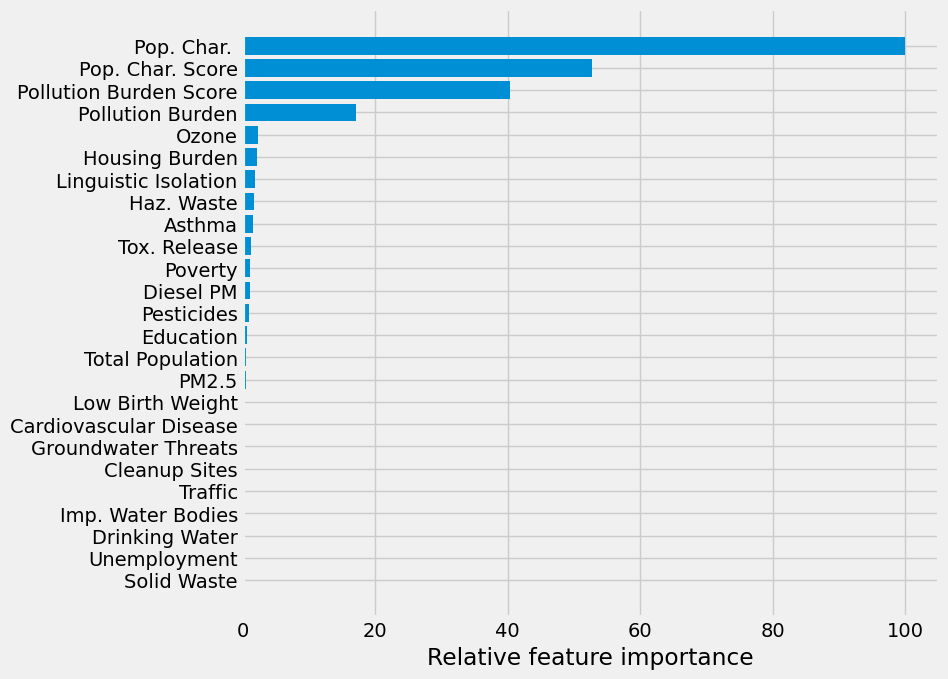

In [22]:
importance_plot(first_tree)

The variables associated with Population Characteristics and Pollution Burden have relatively high importance scores.

-----
## Tuning regression tree hyperparameters <a name = 'hp'></a>

In [23]:
# possible solution
tuned_tree = DecisionTreeClassifier(max_leaf_nodes=5, max_features=25)
tuned_tree.fit(X_train, y_train)

print("Number of features: {}".format(tuned_tree.tree_.n_features))
print("Number of nodes (leaves): {}".format(tuned_tree.tree_.node_count),"\n")

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

Number of features: 25
Number of nodes (leaves): 9 

Train Score:  0.7633928571428571
Validation Score:  0.7857142857142857


Next I will use the RandomizedSearchCV to help me find hyperparameters that lower our error.

In [28]:
# run this cell
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 10)}

rnd_search = RandomizedSearchCV(tuned_tree, param_distributions=param_dist, 
                                cv=10, n_iter=200, random_state = 2020)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=DecisionTreeClassifier(max_features=25,
                                                    max_leaf_nodes=5),
                   n_iter=200,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f00183e0820>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f001845a3a0>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f00183e0bb0>},
                   random_state=2020)

After fitting the data, I can check the values for the parameters that return the "best" score.

In [30]:
print(rnd_search.best_score_) # This is cross validation error from the training data set.
print(rnd_search.best_params_)

0.9096129837702872
{'max_depth': 9, 'max_features': 19, 'max_leaf_nodes': 88}


Next, I set the parameters of `tuned_tree` to the 3 parameters that I found using the randomized search. Then, scored the model using the training and validation sets. 

In [32]:
tuned_tree.set_params(max_features=18, max_leaf_nodes=8, max_depth = 8)
tuned_tree.fit(X_train, y_train)

tuned_train_score = tuned_tree.score(X_train, y_train)
tuned_val_score = tuned_tree.score(X_val, y_val)

print('Train Score: ', tuned_train_score)
print('Validation Score: ', tuned_val_score)

tuned_tree.tree_.node_count

Train Score:  0.8258928571428571
Validation Score:  0.8258928571428571


15

Below I looked into the feature importance score for the tuned_tree.

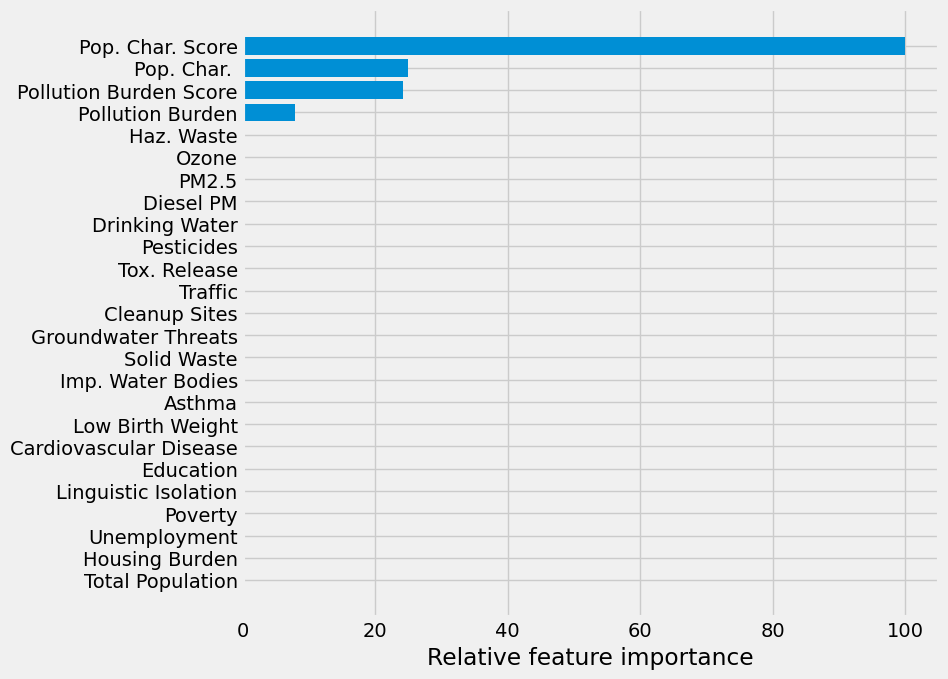

In [33]:
importance_plot(tuned_tree)

----

### Ensemble methods<a name = 'improve'></a>

Because fitting one tree and tuning its hyperparameters caused the training scores to be high, the validation scores usually weren't as high. This is where ensemble methods (namely, bagging, random forests, and boosting) come in.

----
Using the training data (`X_train` and `y_train`) I fit the bagging classifier. I scored the model using the validation data.

In [35]:
# solution
from sklearn.ensemble import BaggingClassifier

bag_tree = BaggingClassifier(random_state = 2020, n_estimators = 125, max_samples = 500, max_features = 20)
bag_tree.fit(X_train, y_train)

bag_train_score = bag_tree.score(X_train, y_train)
bag_val_score = bag_tree.score(X_val, y_val)

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

Train Score:  0.9988839285714286
Validation Score:  0.9419642857142857


----
Next I was trying out random forests using scikit-learn's `RandomForestClassifier()` to implement the model.

The idea behind a random forest is that adding randomization into the features that create the model and then averaging predictions across models will produce a model that is not as overfit to the training data, and is in turn more reliable for prediction.

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf_tree = RandomForestClassifier(random_state=2020)
rf_tree.fit(X_train, y_train)

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

Train Score:  1.0
Validation Score:  0.9285714285714286


I chose values for parameters that affect model performance and passed them in to a new random forest classifier and fit the model and then printed out errors with training and validation data. 

In [39]:
#solution
rf_newparams = RandomForestClassifier(max_features="auto", max_leaf_nodes = None,
                    min_samples_leaf=1, min_samples_split=2, n_estimators=100, 
                    random_state = 3)
rf_newparams.fit(X_train, y_train)

rf_train_score = rf_newparams.score(X_train, y_train)
rf_val_score = rf_newparams.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train Score:  1.0
Validation Score:  0.9419642857142857


----
Lastly, I'll be looking into boosting, I'll focus on `GradientBoostingClassifer` using scikit-learn's `GradientBoostingClassifier`

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gb_tree = GradientBoostingClassifier()
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

Train Score:  1.0
Validation Score:  0.9508928571428571


**Question 4.8** In the case of boosting, cross validation helps with hyperparameter tuning.  Figure out what parameters you'd like to search over, choose a range for them, and pass them into `RandomizedSearchCV` as we did in part 3.  Then save and print out the best parameters. (*NOTE:* This will probably take a while--several minutes!--to run, depending on how many parameters you choose.)

In [49]:
#POSSIBLE SOLUTION

param_dist = {'learning_rate': randint(1, 5),
              #'max_leaf_nodes': randint(3, 100),
              'max_features': randint(2, 25),
              'max_depth': randint(1, 10),
              'min_samples_leaf': randint(1, 30)}

rnd_gb_search = RandomizedSearchCV(gb_tree, param_distributions=param_dist, 
                                cv=10, n_iter=50)

rnd_gb_search.fit(X_train, y_train)

print(rnd_gb_search.best_params_)

C:\Users\jessi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 1, 'max_depth': 7, 'max_features': 13, 'min_samples_leaf': 18}


Once the search was complete, I set the parameters and re-fit and score the model and used the importance plot I created earlier

In [41]:
gb_tree.set_params(learning_rate=1, max_depth=9, max_features=9, max_leaf_nodes=47, 
                   min_samples_leaf=3)
gb_tree.fit(X_train, y_train)

print('Train Score: ', gb_tree.score(X_train, y_train))
print('Validation Score: ', gb_tree.score(X_val, y_val))

Train Score:  1.0
Validation Score:  0.9553571428571429


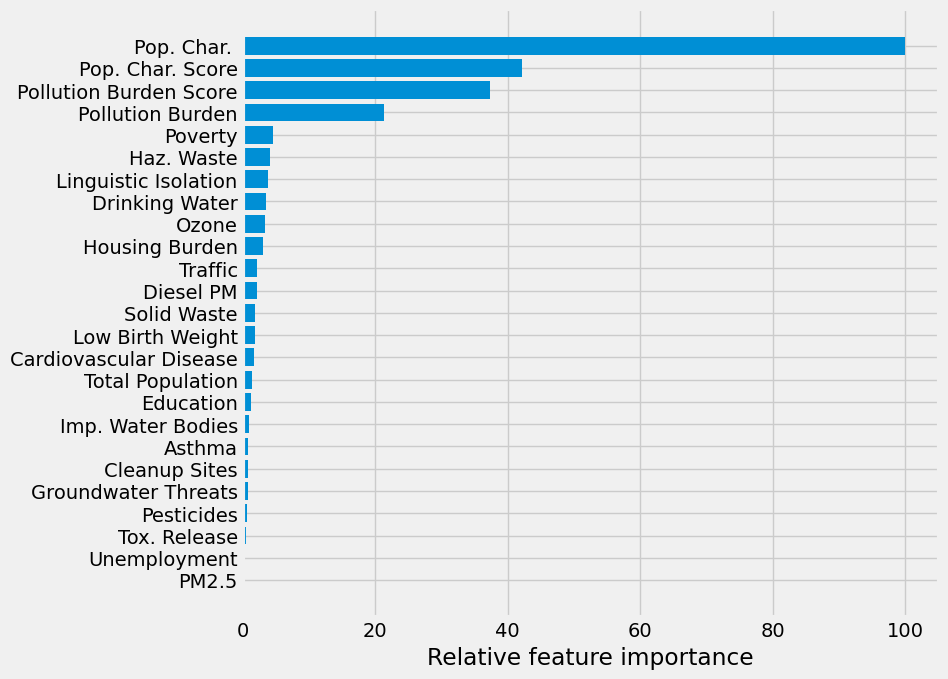

In [42]:
importance_plot(gb_tree)

----

I've gone through many methods of creating a decision tree and tuning and improving it, as well as various algorithms that use multiple trees to create a more reliable prediction. I have been primarily testing models with the training and validation set, so nect I would cross validate each of these models to see which one is the optimal one to choose given our data.

The model that scores the highest on the test data is boosting and the model that scores the lowest is the decision tree.

In [44]:
models = [first_tree, tuned_tree, bag_tree, rf_tree, rf_newparams, gb_tree]
for i in models:
    print('Test Score: ', i.score(X_test, y_test))

Test Score:  0.8689839572192514
Test Score:  0.7352941176470589
Test Score:  0.9064171122994652
Test Score:  0.9010695187165776
Test Score:  0.8957219251336899
Test Score:  0.9064171122994652
